# Load HCP parcellated task data

1.   List item
2.   List item



The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
# Notebook is a project developed during NeuroMatch Academy Computational 2021
# Authors include:
# Matthew Jacobs
# Bahareh Najafi
# Alina Tu
# Colleen Fleury
# Nan Zhang
# Shreeja Dutta

# Code is from HCP data set, and code was built from a Notebook developed for Neuromatch 

# Imports
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.stats import spearmanr

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#Entirely Neuromatch Code

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
# See if we can read the size and pull from there, avoid hardcoding
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# > For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1



```
# This is formatted as code
```


## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)
region_info['network']

array(['Visual1', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Visual2',
       'Visual2', 'Somatomotor', 'Somatomotor', 'Cingulo-Oper',
       'Language', 'Default', 'Visual2', 'Frontopariet', 'Frontopariet',
       'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Visual2',
       'Visual2', 'Visual2', 'Auditory', 'Default', 'Default',
       'Dorsal-atten', 'Default', 'Frontopariet', 'Posterior-Mu',
       'Posterior-Mu', 'Posterior-Mu', 'Posterior-Mu', 'Posterior-Mu',
       'Posterior-Mu', 'Somatomotor', 'Cingulo-Oper', 'Cingulo-Oper',
       'Somatomotor', 'Somatomotor', 'Somatomotor', 'Somatomotor',
       'Cingulo-Oper', 'Cingulo-Oper', 'Cingulo-Oper', 'Language',
       'Somatomotor', 'Visual2', 'Visual2', 'Language', 'Somatomotor',
       'Somatomotor', 'Somatomotor', 'Somatomotor', 'Somatomotor',
       'Somatomotor', 'Cingulo-Oper', 'Cingulo-Oper', 'Cingulo-Oper',
       'Cingulo-Oper', 'Posterior-Mu', 'Posterior-Mu', 'Frontopariet',
       'Posterior-Mu', 'Posterior-

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
# Helper Functions provided by NeuroMatch Academy

def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



# Project Space

Area to load data from data set. Project surrounds decoding stimuli type from a working memeory task (n-back test)



```
# This is formatted as code
```

For n-back test there are 405 time points in 360 regions of interest (ROIs).
There are 8 conditions: first 4 are 0-back and second 4 are 2 back tasks
stimuli include: faces, body parts, tools, and places. There is two runs per participant

Load time series function brings the data for one run for all conditions for one participant. 

load EVS has the time bins for each condition 



Helper Function average_frames 
From Neuromatch

For on participant for one condition, finds average response for each brain region. 

In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)

Helper Functions (GLM)
From Project group

In [ ]:
# single_Participant() pulls the data from the working mememory task into a design matrix
# output: 16 (conditions) X 360 (regions) matrix
# the conditions are in repeating order of same categories
# first 8 are run 1 an second 8 are run 2 

def single_Participant(subj, exp, remove_mean = True):
  """single_Participant creates design matrix for single participant of 16 (trials) x 360 (average brain region activity)

  Args:
    subj (int) : subject number
    exp (str) : experiment key 
    remove_mean (bool) : option to remove mean from data over time series before average time series together (Default True)

  Returns
    designMat (ndarray)

  Organization of rows:
  First 8 rows are of the first run, and the second 8 rows are of the second run.
  Condition order: 
  '0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools'

  """

  #create a blank matrix of zeros
  designMat = np.zeros((16,360),dtype=object)

  #loop through each run
  for i in range(N_RUNS):

    #load the data for the subject, and the experimental information
    data = load_single_timeseries(subject=subj, experiment=exp,run=i, remove_mean=remove_mean)
    evs = load_evs(subject=subj, experiment=exp,run=i)
    
    for j_idx, cond in enumerate(EXPERIMENTS['WM']['cond']):
      if i==1:
        designMat[j_idx+8,:] = average_frames(data, evs, exp, cond)
      else:
        designMat[j_idx,:] = average_frames(data, evs, exp, cond)

  return designMat

In [ ]:
# aggregate_Participants() creates a design matrix with all participants given
# outputs (16*N particpants) x 360 brain region averages

def aggregate_Participants(participant_List, exp, remove_mean = True):
  """
  Loops over given list of participants to make design matrix 16 (trials)*N (paricipants) x 360 (average brain region activity)

  Args:
    participant_List (list of int) : list of participant numbers
    exp (str) : experiment key 
    remove_mean (bool) : option to remove mean from data over time series before average time series together (Default True)

  Returns
    designMat (ndarray)

  Organization of rows:
  (repeat per participant, and order of particpants is same as order in given list)
  First 8 rows are of the first run, and the second 8 rows are of the second run.
  Condition order: 
  '0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools'

  """
  # number of participants in list
  num_participants = len(participant_List)

  # create empty design matrix to fill
  designMat = np.zeros((16*num_participants,360),dtype=object)
  
  # loop through particapants and append their design matrices together
  for i in range(len(participant_List)):
    designMat[i*16:((i*16)+16),:] =  single_Participant(participant_List[i], exp, remove_mean=remove_mean)
  
  return designMat



# collapses matrix so each run is averaged with the other run by each participant 
def average_run(X):
  """
  Loops over design matrix and averages between runs for each participant
  NOTE: this currently works assuming the experiment is working memeory ('WM')
  We can modify it to check number of conditions, but lets only do that if it's necesary

  Args:
    X (ndarray) : design matrix made by helper functions above
 

  Returns
    new_X (ndarray)

  Organization of rows:
  (repeat per participant, and order of particpants is same as order in given list)
  Each 8 rows are a participant averaged over both runs
  Condition order: 
  '0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools'

  """

  #calculate number of participants
  num_participants = len(X)/16
  
  #create empty matrix 
  new_X = np.zeros((8*int(num_participants),360),dtype=object)

  #loop through the original design matrix and average each particpant over their runs
  for i in range(int(num_participants)):

    temp_Mat = (X[i*8:i*8+8,:] + X[i*8+8:i*8+16,:])/2
    new_X[i*8:((i*8)+8),:] = temp_Mat
  
  return new_X

In [ ]:
# Our GLM Function 
# multinomial andd solver is lbfgs

#to do 
#shuffle y feature to test if the model is due to features rather than just 

def classify_GLM(n_subjects, random_Order = True, my_exp = 'WM', avg_Runs = True, penalty = 'l2', remove_mean = True, max_iter = 5000):
  """
  Creates based on give parameters GLM to decode working mememory task stimuli. 

  Args:
    n_subjects (int) : number of participants to use in design matrix
    random_Order (bool) : default True. Randomly select participants or not
    avg_Runs (bool) : whether to average data over runs for participants
    penaty (str) : what penalty to use for GLM (default l2)
    remove_mean (bool) : whether to subtract mean from fmri data
    max_iter (int) : GLM max iterations for GLM solver
 

  Returns
    X (ndarray) : design matrix
    y (ndarray) : labels
    model (GLM?) : GLM model 
    n_scores (ndarray) : cross validation scores
    participant_List (ndarray) : list of particpant numbers


  """
  if random_Order:
    participant_List = np.sort(random.sample(range(0, 339), n_subjects))
  else:
    participant_List = range(0, n_subjects)


  X = aggregate_Participants(participant_List, my_exp, remove_mean=remove_mean)

  if avg_Runs:
    X = average_run(X)

  y = [0,1,2,3]  #x 60 rows y 4 60/4 = 15

  y = y * int((len(X)/4))

  #shuffle is a test, delete if needed
  #shuffle_Order = random.sample(range(0, n_subjects), n_subjects)
  temp = list(zip(y, X))
  random.shuffle(temp)
  y, X = zip(*temp)

  model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty=penalty, max_iter=max_iter)
  # define the model evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
  # evaluate the model and collect the scores
  n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report the model performance
  print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

  model.fit(X,y)

  return X, y, model, n_scores, participant_List



In [ ]:
# GLM Test code
X,y, model, n_scores, participant_List = classify_GLM(120)

Mean Accuracy: 0.985 (0.009)


## Helper Functions

Functions written by Neuromatch organizers for another data set (see below)
https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/fMRI/load_fslcourse.ipynb#scrollTo=3JEPDnAsd_R_



In [ ]:
# functions to be used to get beta weights 

# GLM from FSL data
def get_HRF(duration,TR,peak):
  """
  Really dumb Haemodynamic response function (not physiologically plausible)
  It simply goes up and down linearly from 0 to peak and back down

  Args:
    duration (float) : in seconds
    TR (float)       : in seconds 
    peak (float)     : in seconds

  Returns:
    1D array
  """
  n = int(np.ceil(duration/TR))
  x = np.linspace(0,duration,n)
  h = np.zeros(n)
  h[x<peak]  = x[x<peak]/peak
  h[x>=peak] = (x[x>=peak]-duration)/(peak-duration)
  h = h/np.sum(h)
  return h


def glm(Y,X,C=None,mask=None):
  """
  Run a general linear model

  Args:
    Y (2d array) : time-by-space data matrix
    X (2d array) : time-by-regressors design matrix
    C (2d array) : contrasts-by-regressor contrrast matrix [default=Identity]
    mask (1d array) : spatial mask wherre GLM is run

  Returns:    
    contrast maps
    t-stats
  """
  if C is None:
    C = np.identity(X.shape[1])
  if mask is None:
    mask = np.ones(Y.shape[1])

  # initialise matrices
  beta    = np.zeros((X.shape[1],Y.shape[1]))
  cope    = np.zeros((C.shape[0],Y.shape[1]))
  varbeta = np.zeros_like(beta)
  tstat   = np.zeros_like(beta)

  # solve glm
  beta[:,mask>0] = np.linalg.pinv(X)@Y[:,mask>0]
  # apply contrasts
  cope[:,mask>0] = np.dot(C,beta[:,mask>0])

  # calculate uncertainty (varcope)
  r    = Y - X@beta
  dof  = X.shape[0] - np.linalg.matrix_rank(X)
  sig2 = np.sum(r**2,axis=0)/dof
  varcope = np.outer(C@np.diag(np.linalg.inv(X.T@X))@C.T,sig2)
  # calculate t-stats
  tstat[:,mask] = cope[:,mask] / np.sqrt(varcope[:,mask])

  return cope, tstat

In [ ]:
# returns the beta weights for a single participant
# code modified from FLS data set see link in helper functions above

#question, average runs over each other? make twice as big design matrix?
#or just average beta weights from each particpant X each run?
def single_beta_set(subject,input_data =[],remove_mean=True, plot_evs = False, average_Runs= True):
  
  # HRF
  HRF = get_HRF(duration=10,TR=1,peak=3)

  #load trial info from run 1 
  evs = load_evs(subject=subject, experiment= 'WM', run=0)
  

  #number of time bins
  n = 405

  #turn all of this hard coding stuff into a loop when less sleepy
  #this will also allow
  cond_0 = np.zeros(405)
  cond_0[np.ravel(evs[0])] = 1
  cond_0[np.ravel(evs[4])] = 1
  cond_1 = np.zeros(405)
  cond_1[np.ravel(evs[1])] = 1
  cond_1[np.ravel(evs[5])] = 1 
  cond_2 = np.zeros(405)
  cond_2[np.ravel(evs[2])] = 1
  cond_2[np.ravel(evs[6])] = 1
  cond_3 = np.zeros(405)
  cond_3[np.ravel(evs[3])] = 1
  cond_3[np.ravel(evs[7])] = 1  
         
  ev1 = np.convolve(cond_0,HRF,'full')[:n]
  #print(np.shape(ev1))
  ev2 = np.convolve(cond_1,HRF,'full')[:n]
  ev3 = np.convolve(cond_2,HRF,'full')[:n]
  ev4 = np.convolve(cond_3,HRF,'full')[:n]

  # plot evs
  if plot_evs:
    plt.plot(ev1)
    plt.plot(cond_0)

    plt.figure()
    plt.plot(ev2)
    plt.plot(cond_1)

    plt.figure()
    plt.plot(ev3)
    plt.plot(cond_2)

    plt.figure()
    plt.plot(ev4)
    plt.plot(cond_3)

  # demean the task regressors
  ev1 = ev1 - np.mean(ev1)
  ev2 = ev2 - np.mean(ev2)
  ev3 = ev3 - np.mean(ev3)
  ev4 = ev4 - np.mean(ev4)

  # append a constant regressor
  design_matrix = np.asarray([ev1,ev2,ev3,ev4,np.ones_like(ev1)]).T
  #print(design_matrix.shape)

  input_data = load_single_timeseries(subject=subject,experiment='WM',run=0,remove_mean=remove_mean)
  if average_Runs:
    run2_data = load_single_timeseries(subject=subject,experiment='WM',run=1,remove_mean=remove_mean)
    evs2 = load_evs(subject=subject, experiment= 'WM', run=1)
    #loop through each 
    for i in range(8):
      input_data[:,np.ravel(evs[i])] += run2_data[:,np.ravel(evs2[i])]
    input_data /=2
  # (N-by-time)
  Y = input_data.T

  # create a mask where data is non-zero
  mask = np.sum(Y**2,axis=0)>0

  # run GLM
  beta,t = glm(Y=Y,X=design_matrix,mask=mask)
  
  return design_matrix, Y, beta, t


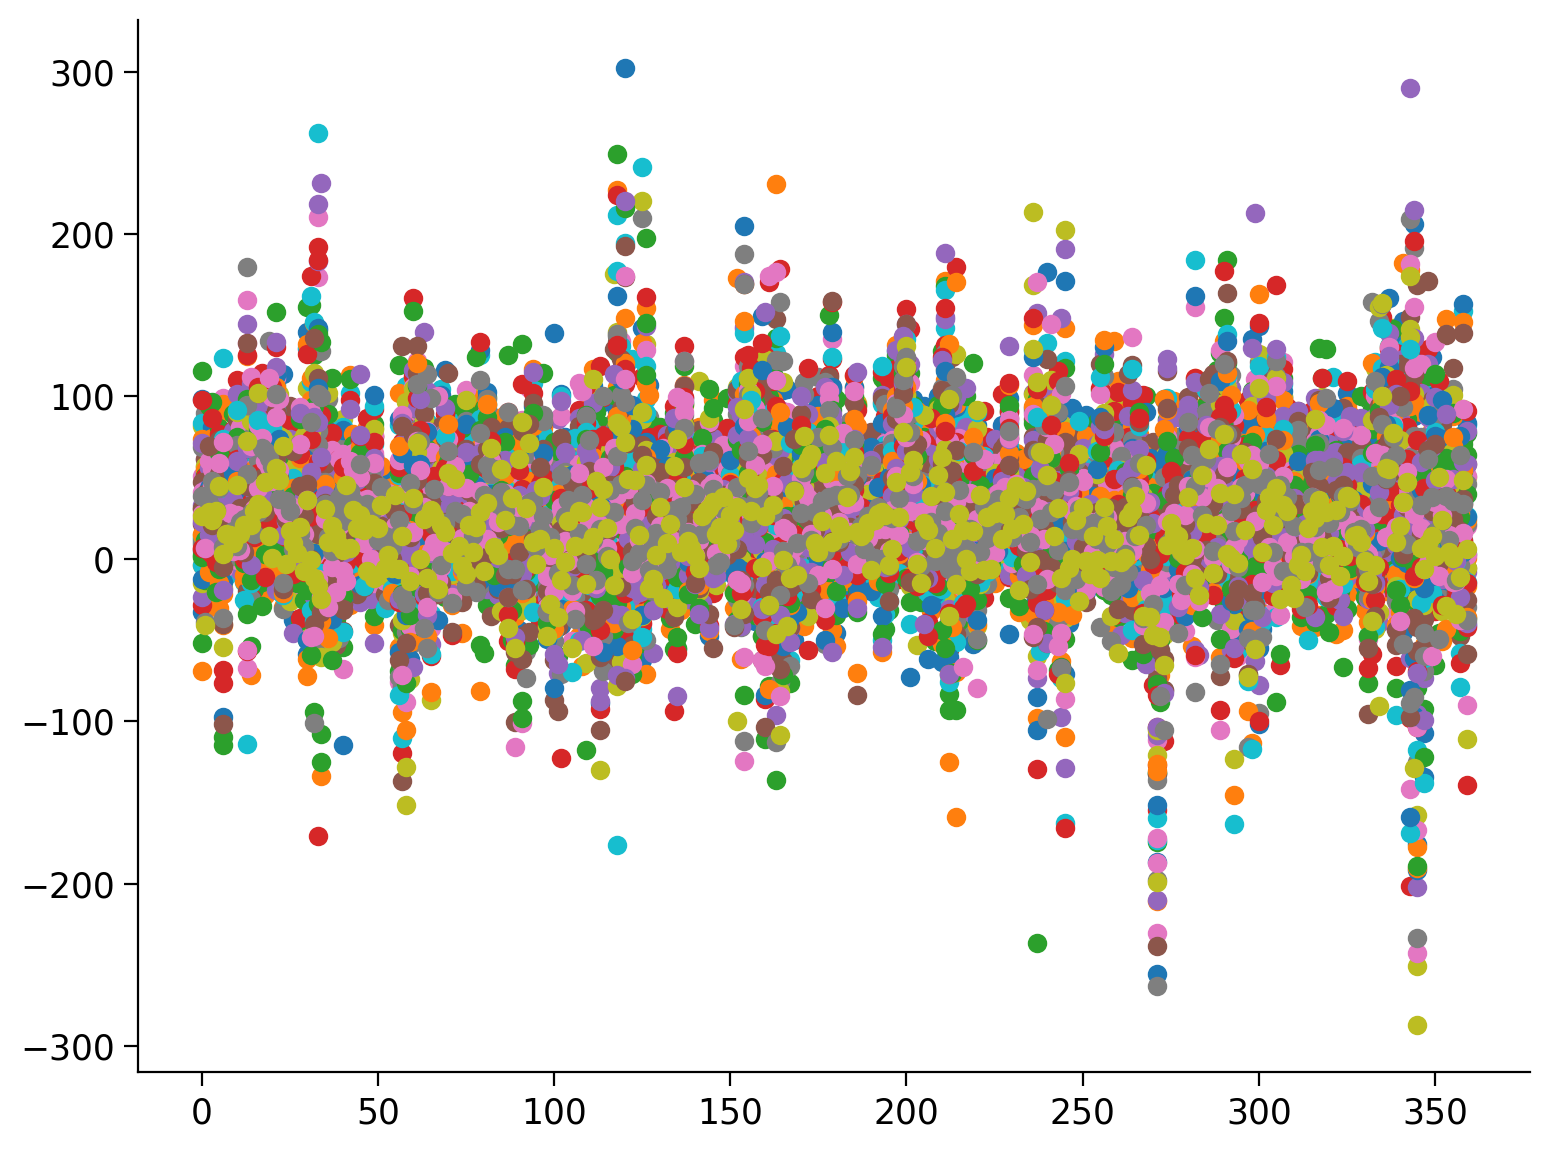

In [ ]:
# This function gets all of the subjects beta weights and returns them in
# subjs[regions,subjects], must specify condition

def get_subjects_beta(condition):
  subjs = np.zeros((360,N_SUBJECTS))

  for i in range(0,N_SUBJECTS):
    subj_id = i
    data = load_single_timeseries(subject=subj_id,experiment='WM',run=0,remove_mean=True)
    design_matrix, Y, beta, t = single_beta_set(subj_id, data)
    subjs[:,i] = beta[condition]

  return subjs

# second version, returns all conditions for efficiency
# This function gets all of the subjects beta weights and returns them in
# subjs[regions,subjects], for all conditions, can limit number of participants 

def get_subjects_beta_all(num_part = N_SUBJECTS):
  subjs_cond0 = np.zeros((360,num_part))
  subjs_cond1 = np.zeros((360,num_part))
  subjs_cond2 = np.zeros((360,num_part))
  subjs_cond3 = np.zeros((360,num_part))

  for i in range(0,num_part):
    subj_id = i
    data = load_single_timeseries(subject=subj_id,experiment='WM',run=0,remove_mean=True)
    design_matrix, Y, beta, t = single_beta_set(subj_id, data)
    subjs_cond0[:,i] = beta[0]
    subjs_cond1[:,i] = beta[1]
    subjs_cond2[:,i] = beta[2]
    subjs_cond3[:,i] = beta[3]

    # transfroms from 360 x 339 to 339 x 360 so in design matrix form 
    beta_conditions = [subjs_cond0.T,subjs_cond1.T,subjs_cond2.T,subjs_cond3.T]

  return beta_conditions

# do we want whole time series ? STILL WORK IN PROGRESS do we want to create overlap threshold?
def get_all_neural_data(num_part = N_SUBJECTS, remove_mean = True):
  '''
  Gets all the nerual data for each participant in 4 (Conditions) x num_part (subjects usually all 339) x 360 (brain regions)

  num_part (int) : number of particpants that you want, default is all
  average_runs (bool) : whether to average over both runs for each participant, default true
  run (int 0 or 1) : if average_runs is false, then which run do you want, default 0
  '''
  
  subjs_cond0 = np.zeros((num_part*2,360,39))
  subjs_cond1 = np.zeros((num_part*2,360,39))
  subjs_cond2 = np.zeros((num_part*2,360,39))
  subjs_cond3 = np.zeros((num_part*2,360,39))
  conditions= [subjs_cond0, subjs_cond1,subjs_cond2, subjs_cond3]
  for i in range(0,num_part):
    subj_id = i
    
    
    data = load_single_timeseries(subject=subj_id,experiment='WM',run=0,remove_mean=remove_mean)
    data2 = load_single_timeseries(subject=subj_id,experiment='WM',run=1,remove_mean=remove_mean)
    evs = load_evs(subject=subj_id, experiment='WM',run=0)
    evs2 = load_evs(subject=subj_id, experiment='WM',run=1)

    for idx, cond_array in enumerate(conditions):
      conditions[idx][i] += (data[:,evs[idx][0]] + data[:,evs[idx + 4][0]])/2 
      conditions[idx][i + num_part] += (data2[:,evs2[idx][0]] + data2[:,evs2[idx + 4][0]])/2

  return conditions
    

    # subjs_cond0[:,i] = beta[0]
    # subjs_cond1[:,i] = beta[1]
    # subjs_cond2[:,i] = beta[2]
    # subjs_cond3[:,i] = beta[3]

# test_data = load_single_timeseries(subject=0,experiment='WM',run=0,remove_mean=True)
#print(np.shape(test_data))

all_data = get_all_neural_data() # 4 item list with each item = [with shape (678,360,39)]


plt.plot(all_data[0][0], "o")


In [ ]:
# regularization function

# applies selected regularization and spits out average beta weights over participants per condition 
# beta_conditions = [4 conditions x 339 subjects x 360 brain regions ]
# will work similarly for neural data
def regularize_betas(beta_conditions, min_max = True, mn_tuple = (-1,1), mean_sub_part = True):
  
  #
  if min_max:
    for cond_idx, cond in enumerate(beta_conditions):
      beta_conditions[cond_idx] = sklearn.preprocessing.minmax_scale(cond,mn_tuple)

    #print(np.shape(beta_conditions))
  # if mean_sub_part:
  #     for i in range(beta_conditions.shape[1]):
  #       print()


  #average over participants 
  reg_avg_betas = [np.mean(cond,0) for cond in beta_conditions]
  
  reg_avg_betas = np.ravel(reg_avg_betas)

  return reg_avg_betas #returns a 360*4 array  

# applies selected regularization and spits out average neural data over participants per condition 
# all_neural_data = [4 conditions x 678 subjects (2*N) x 360 brain regions x 39 ranged timebin]
def regularize_neural_with_timebins(all_neural_data, min_max = True, mn_tuple=(-1,1)):

  #make empty matrix of same size
  reg_all_neural_data = np.zeros_like(all_neural_data)
  if min_max:
    for cond_idx, cond in enumerate(all_neural_data):
      reg_all_neural_data[cond_idx] = regularize_neural_cond(cond, min_max, mn_tuple)
      #print(np.shape(all_neural_data))
     
  return reg_all_neural_data

#recieves N*2 participants(*runs) x 360 regions x 39 time bins (averaged working memory trials)
def regularize_neural_cond(neural_condition, min_max = True, mn_tuple=(-1,1)):
  
  neural_cond_reg = np.zeros_like(neural_condition)

  if min_max: 
    for part_idx, part in enumerate(neural_condition):
      neural_cond_reg[part_idx] = sklearn.preprocessing.minmax_scale(part,mn_tuple) #part is 2d array 360 regions x 39 time bins to transpose for minmax, andd transpose back to fit in structure
      #print(np.shape(neural_condition))
  return neural_cond_reg

def neural_avg_particpants(reg_neural):
  avg_part = np.zeros((4, 360, 39))

  for i in range(len(reg_neural)):#loop through each condition
    index = i*360
    avg_part[i] = (np.mean(reg_neural[i],0)) #N x 360 x 39 
  return avg_part
      


# # regularizes as specified and averages over participants 
#test = regularize_betas(all_data)

# print(np.shape(test))

# plt.plot(test,'o')

# all_data = get_all_neural_data()
# test = regularize_neural_with_timebins(all_data)
# test2 = neural_avg_particpants(test)
# test2_array = np.array(test2)

# print((np.shape(test2)))
# print(np.shape(test))
# print(np.shape(all_data))

#plt.plot(test[0][0], "o")



In [ ]:
# correlation coefficient function

#doesnt work with 1d array like with what Quinn recommended
# works with 360*conds x 39 
def cross_corr(data, plot=True):
  '''
  Takes our data and cross correlates it with itself

  data: 1-d array of brain region data (either one condition ,or all coniditons)
  plot: boolean if you want to plot the cross correlation matrix 
  '''
  
  cross_corr_mat =  np.corrcoef(data)
  
  if plot:
    
    f, ax = plt.subplots(1,1, figsize=(8, 7))
    rank_srm = cross_corr_mat
    cross_corr_mat
    plt.imshow(
      rank_srm, 
      cmap='jet', 
    )
    plt.colorbar()
  return cross_corr_mat

def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count



In [ ]:
# setting up Neural data for cross correlation 
all_data = get_all_neural_data() # gets all neural data into 4 cond x 339 participant x 360 region x 39 time bin
reg_all_data = regularize_neural_with_timebins(all_data) # min_max data, keeps in same shape
avg_neural_conds = neural_avg_particpants(reg_all_data) # averages over participant 4 cond x 360 region x 39 time bin
avg_neural_conds_array = np.array(avg_neural_conds) # change to nd array

#conditions reminder 
#0 = body
#1 = faces
#2 = places
#3 = tools

In [ ]:
# Various concatenations

#all four conditions 
full_anca_concat = np.concatenate(avg_neural_conds_array, axis=0)

# conditions 0 (body) and 1 (faces)
cond02_concat = np.concatenate([avg_neural_conds_array[0],avg_neural_conds_array[2]],axis=0)
cond03_concat = np.concatenate([avg_neural_conds_array[0],avg_neural_conds_array[3]],axis=0)
cond01_concat = np.concatenate([avg_neural_conds_array[0],avg_neural_conds_array[1]],axis=0)
cond23_concat = np.concatenate([avg_neural_conds_array[2],avg_neural_conds_array[3]],axis=0)



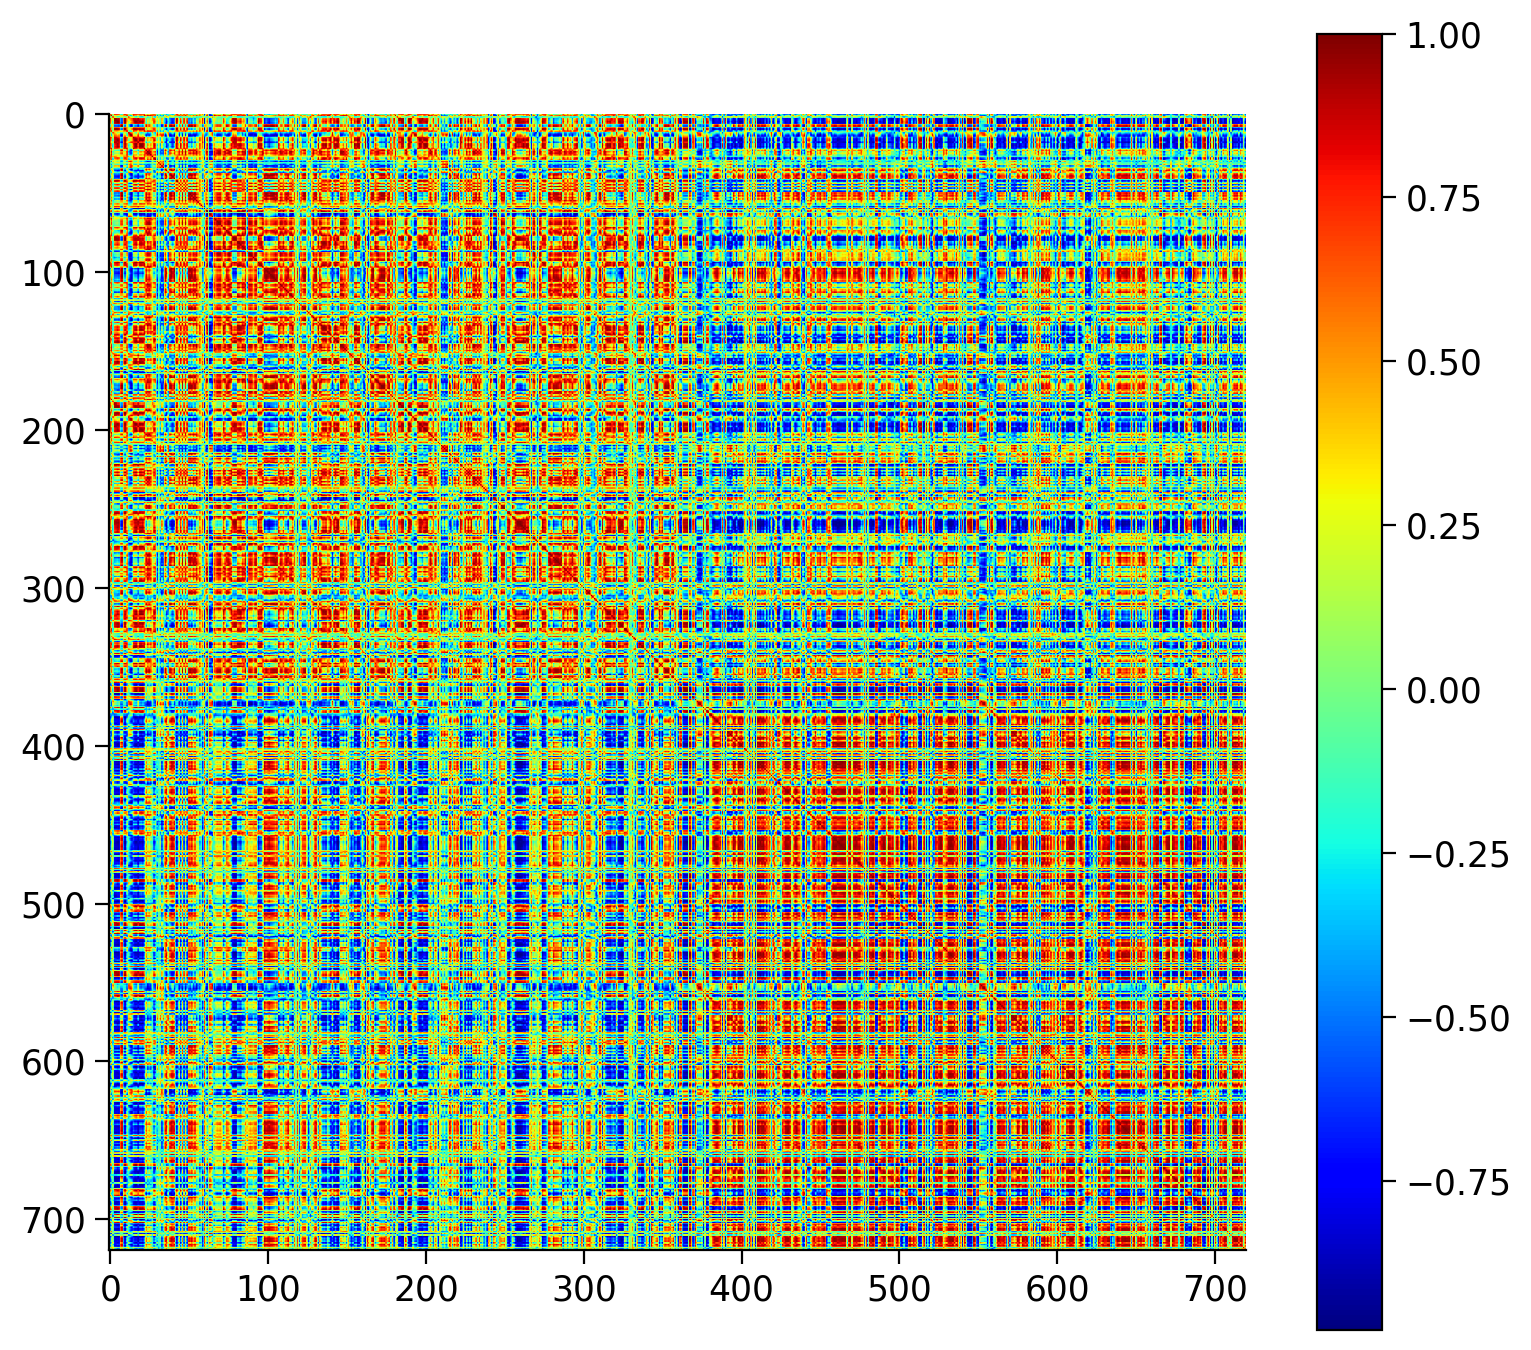

In [ ]:
#Cross corelations

#all correlated
#all_cross_corr = cross_corr(full_anca_concat)

#condition 0 body and condition 2 places
cond02_cross_corr = cross_corr(cond02_concat)
#cond02_selected = cond02_cross_corr[:360,360:]
#plt.figure()
#plt.imshow(cond02_selected.T, cmap = "jet")
#cond03_cross_corr = cross_corr(cond03_concat)
#cond23_cross_corr = cross_corr(cond23_concat)
#cond0_croos_corr = cross_corr(avg_nerual_conds_array[0])
#np.shape(cond0_croos_corr)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


85
['Visual2' 'Posterior-Mu' 'Posterior-Mu' 'Posterior-Mu' 'Posterior-Mu'
 'Posterior-Mu' 'Posterior-Mu' 'Visual1' 'Visual2' 'Frontopariet']


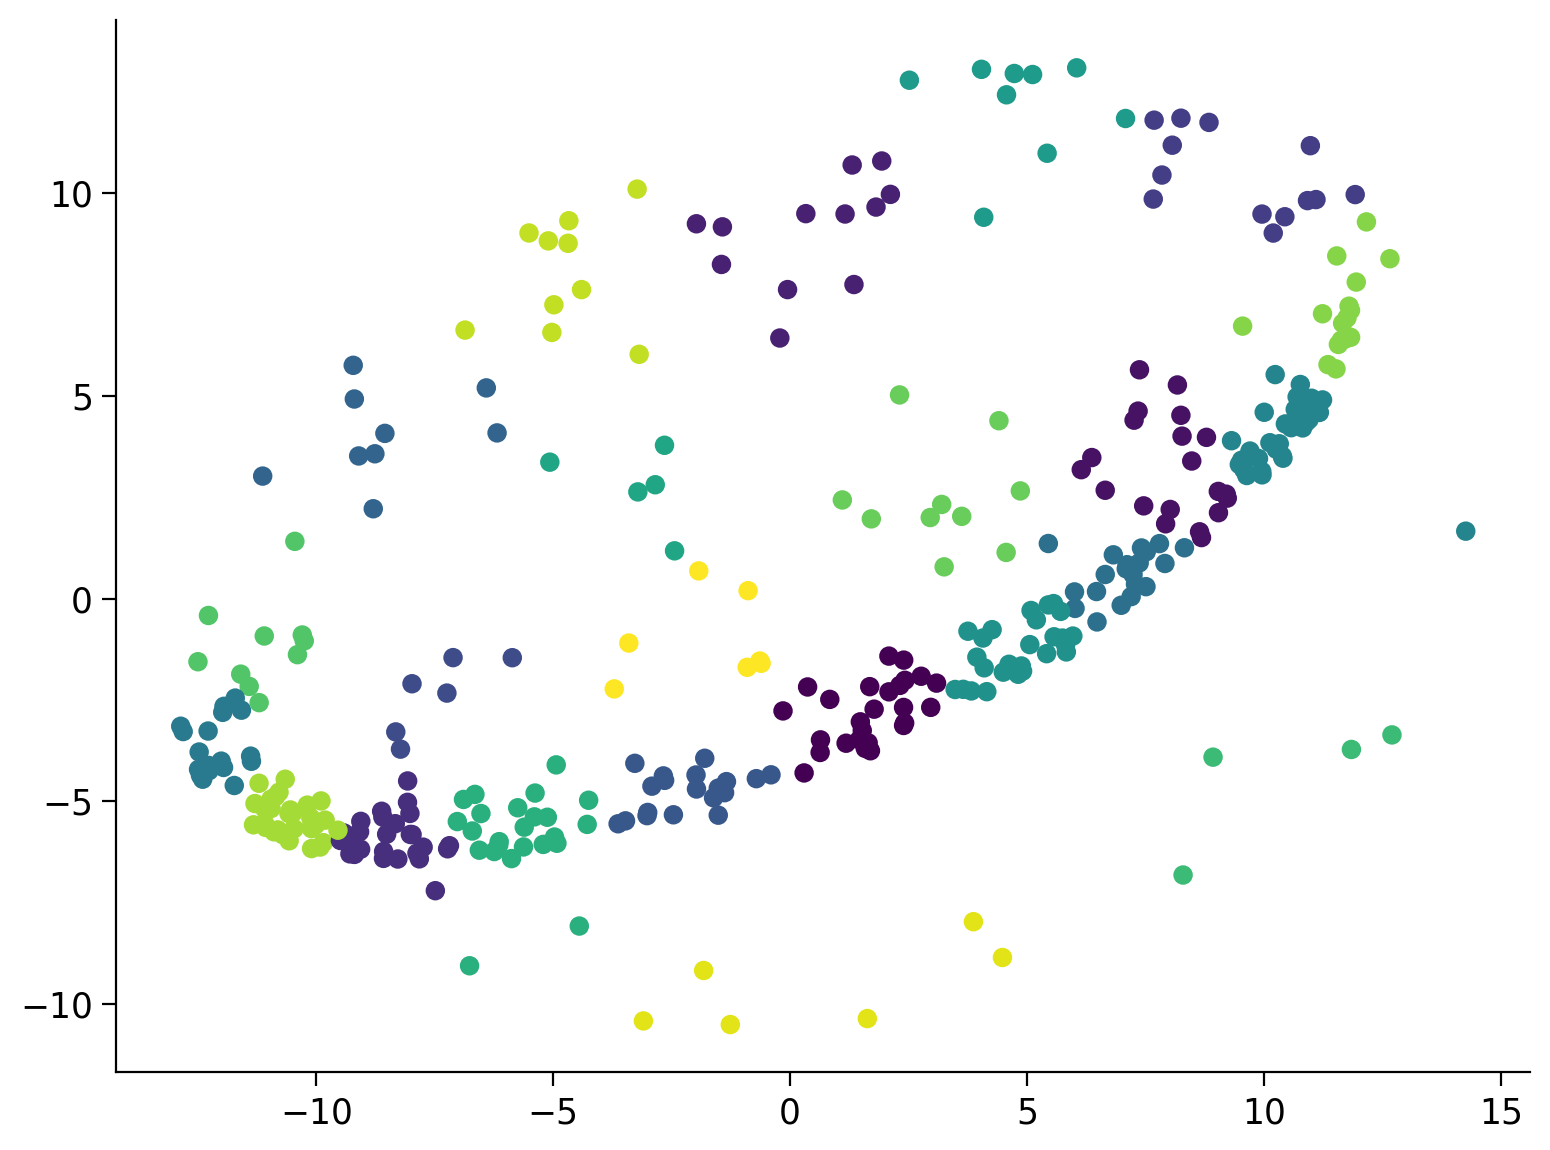

<Figure size 800x600 with 0 Axes>

In [ ]:
#demo One
from mpl_toolkits import mplot3d

#figure it out code
#corrcoef_test2 = np.corrcoef(test2_array_cat)
embedding = MDS(n_components=2, random_state=1)
X_transformed = embedding.fit_transform(cond02_cross_corr[:360,360:])
#print(np.shape(test[0]))
#np.shape(X_transformed)
model = KMeans(n_clusters=23)
labels = model.fit_predict(X_transformed)
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=model.labels_.astype(float))
print(embedding.n_iter_)
fig = plt.figure()
#ax = plt.axes(projection='3d')#
#ax.scatter3D(X_transformed[:,0],X_transformed[:,1], c = X_transformed[:,2]);

region_info['network']
print(region_info['network'][np.where(labels == 20)])

In [ ]:
#demo One
from mpl_toolkits import mplot3d

#figure it out code
#corrcoef_test2 = np.corrcoef(test2_array_cat)
embedding = MDS(n_components=2, random_state=1)
X_transformed = embedding.fit_transform(cond02_cross_corr[:360,360:])
#print(np.shape(test[0]))
#np.shape(X_transformed)
# Setting various plot properties
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, frame_on=True)
fig.set_size_inches(18.5, 10.5)

# Creating a discrete colorbar
colors = plt.cm.rainbow(np.linspace(0, 1, 23))
model = KMeans(n_clusters=23)
labels = model.fit_predict(X_transformed)
current_plot_range = 0
previous_plot_range = 0

for i,c in enumerate(colors):
  
  plt.scatter(X_transformed[:,0], X_transformed[:,1],
       23, lw=.25, marker='o',color = c, label=i, alpha =0.9, antialiased=True, 
       zorder=3)

plt.legend()
#m.fillcontinents(color='#555555')

#plt.scatter(X_transformed[:,0], X_transformed[:,1], c=model.labels_.astype(float))
#print(embedding.n_iter_)
#fig = plt.figure()
#ax = plt.axes(projection='3d')#
#ax.scatter3D(X_transformed[:,0],X_transformed[:,1], c = X_transformed[:,2]);

#region_info['network']
print(region_info['network'][np.where(labels == 20)])

In [ ]:
# Comparison of all to all

run_cross_core = False
plot_cross_cor = False
make_model = True
make_k = True
#cross correlation
if run_cross_core:
  all_cross_corr = cross_corr(full_anca_concat, plot_cross_cor)

#MDS Model
if make_model:
  embedding_all = MDS(n_components=2, random_state=1)
  X_transformed_all = embedding_all.fit_transform(all_cross_corr)

#k-mean
if make_k:
  model = KMeans(n_clusters=23)
  labels = model.fit_predict(X_transformed_all)

fig = plt.figure()


#labels = model.fit_predict(X_transformed_all)
labels = np.concatenate((np.zeros(360),np.ones(360),np.ones(360)+1, np.ones(360)+2))
plt.scatter(X_transformed_all[:,0], X_transformed_all[:,1], c=labels)


#region_info['network']
#print(region_info['network'][np.where(labels == 20)])


In [ ]:
# Comparison of 0 body to 0 body

#cross correlation
if 1:
  cross_corr_00 = cross_corr(avg_neural_conds_array[0], True)
  

#MDS Model
if True:
  embedding_00 = MDS(n_components=2, random_state=1)
  X_transformed_00 = embedding_00.fit_transform(cross_corr_00)

#k-mean
if True:
  model_00 = KMeans(n_clusters=23)
  labels_00 = model.fit_predict(X_transformed_00)


#Find top 5 biggest clusters
num_members = []
for ii in range(np.max(labels_00)):
 num_members.append(len(labels_00[labels_00==ii]))

top_5_00 = np.argsort(num_members)[-5:]

cluster_regions = [[]]*5
for idx, top in enumerate(top_5_00):
  #print(region_info['network'][np.where(labels_00 == i)])
  cluster_regions[idx] = region_info['network'][np.where(labels_00 == top)]



#count the occurences of brain regions in each cluster
brain_regions = np.unique(region_info['network'])

counts = np.zeros((5,len(brain_regions)))
for idx_cl, cluster in enumerate(cluster_regions):
  for idx_r, reg in enumerate(brain_regions):
    counts[idx_cl,idx_r] += countX(cluster, reg)

#print(counts)
print(brain_regions)

for test in range(5):
  plt.bar(range(12), counts[test])
  fig = plt.figure()

fig = plt.figure()




plt.scatter(X_transformed_00[:,0], X_transformed_00[:,1], c=labels_00)


#print(region_info['network'][np.where(labels_00 == 1)])


In [ ]:
 counts[0,0], counts[1, 0], counts[2,0], counts[3, 0], counts[4,0]
def check(number):
     res =  number % 360
     return res

def update_index(aa):
    res = []
    for item in list(aa[0]):
        res.append(check(item))


(list(aa)[0])
#[cluster_unique.tolist()[ii]]
np.shape(cluster_regions[3])
#(Counter(cluster)[cluster_unique.tolist()[ii]])
np.shape(list(np.where(labels_00 == top)))
type(aa)
b = tuple((res_int % 360))
b

In [ ]:
from collections import Counter
barWidth = 0.15
#common_counts = [[Counter(cluster_regions[0])['Cingulo-Oper'], Counter(cluster_regions[0])['Frontopariet'], Counter(cluster_regions[0])['Visual2']], [Counter(cluster_regions[1])['Cingulo-Oper'], Counter(cluster_regions[1])['Frontopariet'], Counter(cluster_regions[1])['Visual2']], [Counter(cluster_regions[2])['Cingulo-Oper'], Counter(cluster_regions[2])['Frontopariet'], Counter(cluster_regions[2])['Visual2']], [Counter(cluster_regions[3])['Cingulo-Oper'], Counter(cluster_regions[3])['Frontopariet'], Counter(cluster_regions[3])['Visual2']], [Counter(cluster_regions[4])['Cingulo-Oper'], Counter(cluster_regions[4])['Frontopariet'], Counter(cluster_regions[4])['Visual2']]]
common_counts = [[Counter(cluster_regions[0])['Cingulo-Oper'], Counter(cluster_regions[0])['Somatomotor'], Counter(cluster_regions[0])['Visual2']], [Counter(cluster_regions[1])['Cingulo-Oper'], Counter(cluster_regions[1])['Somatomotor'], Counter(cluster_regions[1])['Visual2']], [Counter(cluster_regions[2])['Cingulo-Oper'], Counter(cluster_regions[2])['Somatomotor'], Counter(cluster_regions[2])['Visual2']], [Counter(cluster_regions[3])['Cingulo-Oper'], Counter(cluster_regions[3])['Somatomotor'], Counter(cluster_regions[3])['Visual2']], [Counter(cluster_regions[4])['Cingulo-Oper'], Counter(cluster_regions[4])['Somatomotor'], Counter(cluster_regions[4])['Visual2']]]


# Set position of bar on X axis
r1 = np.arange(len(common_counts[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, common_counts[0], color='r', width=barWidth, edgecolor='white', label='clst0')
plt.bar(r2, common_counts[1], color='g', width=barWidth, edgecolor='white', label='clst1')
plt.bar(r3, common_counts[2], color='b', width=barWidth, edgecolor='white', label='clst2')
plt.bar(r4, common_counts[3], color='m', width=barWidth, edgecolor='white', label='clst3')
plt.bar(r5, common_counts[4], color='c', width=barWidth, edgecolor='white', label='clst4')
 
 
# Add xticks on the middle of the group bars
plt.xlabel('brain region', fontweight='bold')
plt.ylabel('Number of occurance', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(common_counts[0]))], ['Cingulo-Oper', 'Somatomotor', 'Visual2'])
 
# Create legend & Show graphic
leg = plt.legend(loc='center right')
plt.show()#np.arange(np.shape(count)[0])


In [ ]:
 #Comparison of 0 body to 0 body
from collections import Counter
#cross correlation
if 1:
  #cross_corr_00 = cross_corr(avg_neural_conds_array[1], True)
  cross_corr_00 = cross_corr(full_anca_concat, True)
#MDS Model
if True:
  embedding_00 = MDS(n_components=2, random_state=1)
  X_transformed_00 = embedding_00.fit_transform(cross_corr_00)

#k-mean
if True:
  model_00 = KMeans(n_clusters=18)
  labels_00 = model.fit_predict(X_transformed_00)


#Find top 5 biggest clusters
num_members = []
for ii in range(np.max(labels_00)):
    num_members.append(len(labels_00[labels_00==ii]))

top_5_00 = np.argsort(num_members)[-5:]

cluster_regions = [[]]*5
for idx, top in enumerate(top_5_00):
  #print(region_info['network'][np.where(labels_00 == i)])
  aa  = np.where(labels_00 == top)
  aa_array = np.array(list(aa))
  res_int = aa_array.astype(int)
  cluster_regions[idx] = region_info['network'][tuple((res_int % 360))]




#count the occurences of brain regions in each cluster
brain_regions = np.unique(region_info['network'])

counts = np.zeros((5,2), dtype=object)
for idx_cl in np.arange(len(cluster_regions)):
    cluster = cluster_regions[idx_cl]
    cluster_unique = np.unique(cluster_regions[idx_cl])
    count = np.zeros((1, len(np.unique(cluster_regions[idx_cl]))))
    for ii in np.arange(np.shape(count)[1]):
        count[0, ii] = Counter(cluster)[cluster_unique.tolist()[ii]]
        #print(ii, count[0,ii])

    counts[idx_cl,1] = count
    counts[idx_cl,0] = cluster_unique

#print(counts)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.xlabel('brain region', fontweight='bold')
plt.ylabel('Number of occurance', fontweight='bold')
ax.bar(counts[0,0].tolist(), counts[0,1].tolist()[0])
#ax.bar(counts[1,0].tolist(), counts[1,1].tolist()[0])
#ax.bar(counts[2,0].tolist(), counts[2,1].tolist()[0])
#ax.bar(counts[3,0].tolist(), counts[3,1].tolist()[0])
#ax.bar(counts[4,0].tolist(), counts[4,1].tolist()[0])

#plt.xlabel('', fontweight='bold')
#plt.ylabel('Multidimensional Scaling', fontweight='bold')
#plt.scatter(X_transformed_00[:,0], X_transformed_00[:,1], c=labels_00)


In [ ]:
# Comparison of 1 faces to 1 faces

#cross correlation
if True:
  cross_corr_11 = cross_corr(avg_neural_conds_array[1], True)

#MDS Model
if True:
  embedding_11 = MDS(n_components=2, random_state=1)
  X_transformed_11 = embedding_11.fit_transform(cross_corr_11)

#k-mean
if True:
  model_11 = KMeans(n_clusters=23)
  labels_11 = model.fit_predict(X_transformed_11)



fig = plt.figure()


#labels = model.fit_predict(X_transformed_all)

plt.scatter(X_transformed_11[:,0], X_transformed_11[:,1], c=labels_11)


#region_info['network']
print(region_info['network'][np.where(labels_11 == 1)])

In [ ]:
# Comparison of 2 places to 2 places

#cross correlation
if True:
  cross_corr_22 = cross_corr(avg_neural_conds_array[2], True)

#MDS Model
if 1:
  embedding_22 = MDS(n_components=2, random_state=1)
  X_transformed_22 = embedding_22.fit_transform(cross_corr_22)

#k-mean
if 1:
  model_22 = KMeans(n_clusters=23)
  labels_22 = model.fit_predict(X_transformed_22)

fig = plt.figure()


#labels = model.fit_predict(X_transformed_all)

plt.scatter(X_transformed_22[:,0], X_transformed_22[:,1], c=labels_22)


#region_info['network']
print(region_info['network'][np.where(labels_22 == 1)])

In [ ]:
# Comparison of 3 tools to 3 tools

#cross correlation
if True:
  cross_corr_33 = cross_corr(avg_neural_conds_array[3], True)

#MDS Model
if 1:
  embedding_33 = MDS(n_components=2, random_state=1)
  X_transformed_33 = embedding_33.fit_transform(cross_corr_33)

#k-mean
if 1:
  model_33 = KMeans(n_clusters=23)
  labels_33 = model.fit_predict(X_transformed_33)

fig = plt.figure()


#labels = model.fit_predict(X_transformed_all)

plt.scatter(X_transformed_33[:,0], X_transformed_33[:,1], c=labels_33)


#region_info['network']
print(region_info['network'][np.where(labels_33 == 1)])

In [ ]:
#Comparison of 0 body to 2 places

#concatenation 
cond02_concat = np.concatenate([avg_neural_conds_array[0],avg_neural_conds_array[2]],axis=0)



#cond02_selected = cond02_cross_corr[:360,360:]
if True:
  cross_corr_02 = cross_corr(cond02_concat, True)
  cross_corr_02 = cross_corr_02[:360,360:]

#MDS Model
if False:
  embedding_02 = MDS(n_components=2, random_state=1)
  X_transformed_02 = embedding_02.fit_transform(cross_corr_02)

#k-mean
if True:
  model_02 = KMeans(n_clusters=23)
  labels_02 = model.fit_predict(X_transformed_02)

fig = plt.figure()


#labels = model.fit_predict(X_transformed_all)


plt.scatter(X_transformed_02[:,0], X_transformed_02[:,1], c=labels_02)


#region_info['network']
print(region_info['network'][np.where(labels_02 == 1)])


In [ ]:
type(X_transformed)

In [ ]:
 # cond23
 kmeans = KMeans(n_clusters=23, random_state=0).fit(X_transformed)
kmeans.n_iter_, kmeans.inertia_, kmeans.labels_

In [ ]:
#cond02
kmeans02 = KMeans(n_clusters=20, random_state=0).fit(X_transformed)
kmeans02.n_iter_, kmeans02.inertia_, kmeans02.labels_

In [ ]:
clusters = kmeans.labels_
num_members = []
for ii in range(16):
 num_members.append(len(clusters[clusters==ii]))


(num_members)

In [ ]:
clusters = kmeans.labels_
num_members = []
for ii in range(16):
 num_members.append(len(clusters[clusters==ii]))


(num_members)

In [ ]:
labels = np.concatenate((np.zeros(360), np.ones(360)))
plt.figure()
ax = plt.subplot(projection = "3d")
ax.scatter(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=labels, s=50, cmap = "plasma") #blue- body, yellow- places


In [ ]:
# cond23
colors = ['red', 'green', 'blue', 'orange', 'purple', 'black', 'gray', 'brown', 'pink', 'olive', 'cyan', 'rosybrown', 'lightcoral', 'papayawhip', 'chartreuse', 'plum', 'navy', 'yellow', 'darkgreen', 'lightblue', 'darkblue', 'darkorange', 'magenta']
for j in range(23):
    filtered_label = X_transformed[clusters==j]
    plt.scatter(filtered_label[:,0] , filtered_label[:,1] , color = colors[j])

In [ ]:
#cond02

colors = ['red', 'green', 'blue', 'orange', 'purple', 'black', 'gray', 'brown', 'pink', 'olive', 'cyan', 'rosybrown', 'lightcoral', 'papayawhip', 'chartreuse', 'plum', 'navy', 'yellow', 'darkgreen', 'lightblue']
fig = plt.figure()
ax = plt.axes(projection='3d')#
for j in range(20):
    filtered_label = X_transformed[clusters==j]
    #plt.scatter(filtered_label[:,0] , filtered_label[:,1] ,  color = colors[j])
    ax.scatter3D(filtered_label[:,0] , filtered_label[:,1] ,filtered_label[:,2],  color = colors[j])

In [ ]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'black', 'gray', 'brown', 'pink', 'olive', 'cyan', 'rosybrown', 'lightcoral', 'papayawhip', 'chartreuse', 'plum', 'navy', 'yellow', 'darkgreen', 'lightblue']
for j in range(16):
    filtered_label = X_transformed[clusters==j]
    plt.scatter(filtered_label[:,0] , filtered_label[:,1] , color = colors[j])

In [ ]:
# evs aren't the same check -> discover most first runs are same as most first 
# runs, and most second runs are same as most second runs (though first and second different)
# and some just differ from that


evs = load_evs(subject=0, experiment='WM',run=0)
evs2 = load_evs(subject=0, experiment='WM',run=1)
evs3 = load_evs(subject=1, experiment='WM',run=0)
evs4 = load_evs(subject=1, experiment='WM',run=1)
# print(np.array_equal(evs,evs2))
# print(np.shape(evs))
# print(evs[0][0])
# print(evs2[0][0])
# print(evs3[0][0])
# print(evs4[0][0])
cond1 = 0
cond2 = 0
cond3 = 0
cond4 = 0
cond5 = 0
cond6 = 0
cond7 = 0
cond8 = 0

evs = load_evs(subject=338, experiment='WM',run=0)
evs = load_evs(subject=338, experiment='WM',run=1)
for i in range(338): 
  
  evs_3 = load_evs(subject=i, experiment='WM', run=0 )
  evs_3 = load_evs(subject=i, experiment='WM', run=0 )
  cond1 = len(evs[0][0])==len(evs_3[0][0])
  cond2 = len(evs[1][0])==len(evs_3[1][0])
  cond3 = len(evs[2][0])==len(evs_3[2][0])
  cond4 = len(evs[3][0])==len(evs_3[3][0])
  cond5 = len(evs[4][0])==len(evs_3[4][0])
  cond6 = len(evs[5][0])==len(evs_3[5][0])
  cond7 = len(evs[6][0])==len(evs_3[6][0])
  cond8 = len(evs[7][0])==len(evs_3[7][0])
  Conditions = [cond1, cond2, cond3, cond4, cond5, cond6, cond7, cond8]
  # print(Conditions)
  # print(evs)
for j in range(8):
  len(evs[j][0])
  print(len(evs[j][0]))
#   run1 = evs[0][0] == load_evs(subject=i, experiment='WM',run=0)[0][0]
#   run2 = evs2[0][0] == load_evs(subject=i, experiment='WM',run=1)[0][0]
#   print("run1")
#   print(run1)
#   print("run2 ")
#   print(run2)
  

In [ ]:

# #more old code. Move to old code section 

# (f, ax = plt.subplots(1,1, figsize=(8, 7))
# #rank_srm, _ = spearmanr(avg_subj_beta)
# #np.corrcoef(avg_subj_beta)
# plt.imshow(
# np.corrcoef(reg_subj_beta),    cmap='jet', 
# )
# plt.colorbar()

# f, ax = plt.subplots(1,1, figsize=(8, 7))
# #rank_srm, _ = spearmanr(avg_subj_beta)
# #np.corrcoef(avg_subj_beta)
# plt.imshow(
# np.corrcoef(app_design_matrix),    cmap='jet', 
# )
# plt.colorbar()

# f, ax = plt.subplots(1,1, figsize=(8, 7))
# #rank_srm, _ = spearmanr(avg_subj_beta)
# #np.corrcoef(avg_subj_beta)
# plt.imshow(
# np.corrcoef(app_subj_beta),    cmap='jet', 
# )
# plt.colorbar()

# # ROIs related to highest beta weights
# cond_0_ROIs = np.abs(beta[0,:]).argsort()[-10:][::-1]
# cond_1_ROIs = np.abs(beta[1,:]).argsort()[-10:][::-1]
# cond_2_ROIs = np.abs(beta[2,:]).argsort()[-10:][::-1]
# cond_3_ROIs = np.abs(beta[3,:]).argsort()[-10:][::-1]
# np.intersect1d(cond_0_ROIs,cond_1_ROIs)

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'lf_activity' : lf_activity,
                   'rf_activity' : rf_activity,
                   'network'     : region_info['network'],
                   'hemi'        : region_info['hemi']})

fig,(ax1,ax2) = plt.subplots(1,2)
sns.barplot(y='network', x='lf_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rf_activity', data=df, hue='hemi',ax=ax2)

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be suubtle at the single subject/session level (these are a quick 3-4min scans). 


Let us boost thee stats by averaging across all subjects and runs. 

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'lf')
    rf_activity = average_frames(data, evs, my_exp, 'rf')

    contrast    = lf_activity-rf_activity
    group_contrast        += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:

df = pd.DataFrame({'contrast':group_contrast,'network':region_info['network'],'hemi':region_info['hemi']})
# we will plot the left foot minus right foot contrast so we only need one plot
sns.barplot(y='network', x='contrast', data=df, hue='hemi')

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
# This uses the nilearn package
!pip install nilearn --quiet
from nilearn import plotting, datasets

# NMA provides an atlas 
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download
with np.load(fname) as dobj:
  atlas = dict(**dobj)

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

In [ ]:
# old codde part 2



# Regularization through min-maxing

subjects_cond0 = get_subjects_beta(0)
print(np.shape(subjects_cond0))

max_sub = np.argmax(subjects_cond0,axis=1)

#print(np.unravel_index(np.argmax(subjects_cond0, axis=None), subjects_cond0.shape))
#print(np.unravel_index(np.argmin(subjects_cond0, axis=None), subjects_cond0.shape))

beta_min_max = sklearn.preprocessing.minmax_scale(subjects_cond0.T,(-1,1))

#beta_min_max = sklearn.preprocessing.minmax_scale(x,(np.amin(beta),np.amax(beta)))

#print(beta_min_max)

plt.plot(np.mean(beta_min_max,0),'o') 
print(np.shape(beta_min_max))





#Also Old Code? What does it do and what does it do?

from skimage.measure import block_reduce
arr_reduced = block_reduce(designMat60, block_size=(5, 360), func=np.mean, cval=np.mean(designMat60))







# Old code. Can we delete?

# load_single_timeseries()

designMat60 = np.zeros((960,360),dtype=object)
condition = EXPERIMENTS['WM']['cond']

my_exp  = 'WM'
#my_subj = 100
my_run  = 0 # 0, 1
sub_list = range(0, 300, 5)
for ii in range(len(sub_list)):
  my_subj=sub_list[ii]
  for i in range(N_RUNS):
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=i,remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp,run=i)
    for j in range(len(condition)):
      if i:
        designMat60[16*ii+8:16*ii+16,:] = average_frames(data, evs, my_exp, condition[j])
        #print((designMat60[16*ii+8:16*ii+16,:]))
      else:
        designMat60[16*ii:16*ii+8,:] = average_frames(data, evs, my_exp, condition[j])


# load_single_timeseries()

designMat20 = np.zeros((320,360),dtype=object)
condition = EXPERIMENTS['WM']['cond']

my_exp  = 'WM'
#my_subj = 100
my_run  = 0 # 0, 1
sub_list = range(0, 300, 15)
for ii in range(len(sub_list)):
  my_subj=sub_list[ii]
  for i in range(N_RUNS):
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=i,remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp,run=i)
    for j in range(len(condition)):
      if i:
        designMat20[16*ii+8:16*ii+16,:] = average_frames(data, evs, my_exp, condition[j])
        #print((designMat60[16*ii+8:16*ii+16,:]))
      else:
        designMat20[16*ii:16*ii+8,:] = average_frames(data, evs, my_exp, condition[j])


# load_single_timeseries()

designMat60 = np.zeros((960,360),dtype=object)
condition = EXPERIMENTS['WM']['cond']

my_exp  = 'WM'
#my_subj = 100
my_run  = 0 # 0, 1
sub_list = range(0, 300, 5)
for ii in range(len(sub_list)):
  my_subj=sub_list[ii]
  for i in range(N_RUNS):
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=i,remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp,run=i)
    for j in range(len(condition)):
      if i:
        designMat60[16*ii+8:16*ii+16,:] = average_frames(data, evs, my_exp, condition[j])
        #print((designMat60[16*ii+8:16*ii+16,:]))
      else:
        designMat60[16*ii:16*ii+8,:] = average_frames(data, evs, my_exp, condition[j])

# load_single_timeseries()

designMat30 = np.zeros((480,360),dtype=object)
condition = EXPERIMENTS['WM']['cond']

my_exp  = 'WM'
#my_subj = 100
my_run  = 0 # 0, 1

for ii in range(0, 30):
  my_subj=ii
  for i in range(N_RUNS):
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=i,remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp,run=i)
    for j in range(len(condition)):
      if i:
        designMat30[16*ii+8:16*ii+16,:] = average_frames(data, evs, my_exp, condition[j])
        #print((designMat60[16*ii+8:16*ii+16,:]))
      else:
        designMat30[16*ii:16*ii+8,:] = average_frames(data, evs, my_exp, condition[j])



#test function + play with data afterwards
subj_id = 300
data = load_single_timeseries(subject=subj_id,experiment='WM',run=0,remove_mean=True)
design_matrix, Y, beta, t = single_beta_set(subj_id, data)

#plt.hist(beta[3,:],histtype='bar',alpha=0.75)

# scatterplot between ROIs and averaged beta weights across conditions (EVs) for single subject
avg_cond_beta = np.mean(beta[0:4,:],0)
#plt.plot(avg_cond_beta,'o')
plt.plot(beta[0,:],'o') # beta weights per condition


#load data for subject for each run

subj_id =300
data = load_single_timeseries(subject=subj_id,experiment='WM',run=1,remove_mean=True)
#data_2 = load_single_timeseries(subject=subject,experiment='WM',run=1,remove_mean=remove_mean)
#data = (data + data_2) / 2

  
design_matrix, Y, beta, t = single_beta_set(subj_id, data)
# scatterplot between ROIs and averaged beta weights across conditions (EVs) for single subject
avg_cond_beta = np.mean(beta[0:4,:],0)
plt.plot(beta[1,:],'o')

#load data for subject for each run
subj_id =300
data_1 = load_single_timeseries(subject=subj_id,experiment='WM',run=0,remove_mean=True)
data_2 = load_single_timeseries(subject=subj_id,experiment='WM',run=1,remove_mean=True)
data = (data_1 + data_2) / 2

  
design_matrix, Y, beta, t = single_beta_set(subj_id, data)
# scatterplot between ROIs and averaged beta weights across conditions (EVs) for single subject
#avg_cond_beta = np.mean(beta[0:4,:],0)
plt.plot(beta[1,:],'o')

# scatterplot between ROIs and averaged beta weights across conditions (EVs), averaging 100 subjects
avg_subj_beta = np.zeros((5,360))
for i in range(100):
  design_matrix, Y, beta, t = single_beta_set(i)
  avg_subj_beta += beta
avg_subj_beta /= 100

print(avg_subj_beta)
avg_cond_beta = np.mean(avg_subj_beta[0:4,:],0)
plt.plot(avg_cond_beta,'o')

app_subj_beta = np.zeros((400,360))
app_design_matrix = np.zeros((400, 405))
reg_subj_beta = np.zeros((100, 360))
for i in range(100):
  design_matrix, Y, beta, t = single_beta_set(i)
  app_subj_beta[4*i:4*i + 4, :] = beta[:4, :]
  app_design_matrix[4*i:4*i + 4, :] = design_matrix[:, :4].T
  # across regions
  reg_subj_beta[i,:] = np.mean(beta[:4, :])
  

app_design_matrix